# Import Packages, Functions and Data

In [1]:
import titanlib
import geopandas
import pandas as pd
import netCDF4
import numpy as np

from mpl_toolkits.axes_grid1 import make_axes_locatable
import datetime
import time



# Import custom version of titanlib containing changes
import titanlibcustom



# Import Formatted Data and functions from other Python script
from Data_Importation_and_Function_Definition import ROI_counties, NI_counties, rain_wow, rain_wow_hourly_obs, temp_wow, rain_official, temp_official, isolate_data_of_interest, plot_wow_data

Note: As advised, the Official Rainfall Rate column is currently beign set as equal to the 
Rainfall Accumulation Hourly column


# Obtain Test Data

In [2]:
gdf_temp_wow, gdf_temp_official, gdf_temp_combined = isolate_data_of_interest(day_of_interest="15", 
                                                                              month_of_interest="05",
                                                                              year_of_interest="2021", 
                                                                              time_of_interest="10",
                                                                              type_of_data="Temperature", 
                                                                              add_elevation_bool=True,
                                                                              remove_missing_val=True, 
                                                                              cols_to_remove_missing_val=["Air Temperature"])

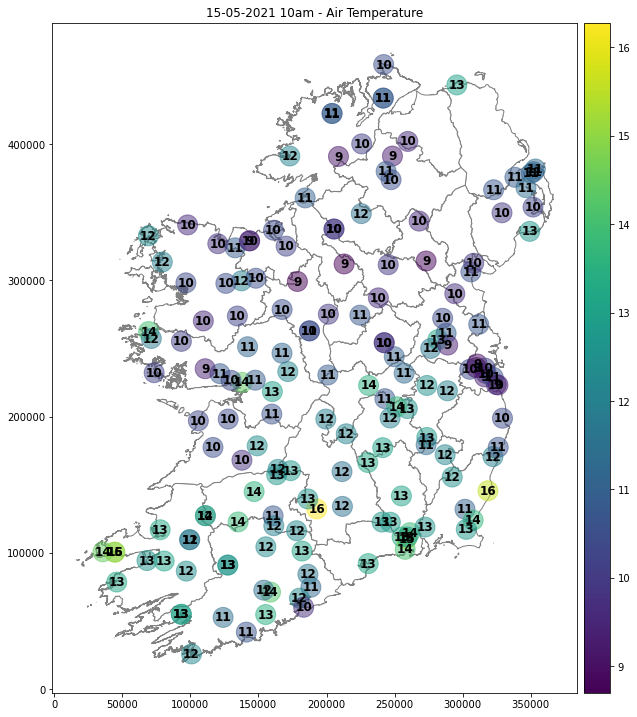

In [3]:
plot_wow_data(gdf_of_interest = gdf_temp_combined, type_of_plot = "Air Temperature", 
              buffer_val = 0, flags = None)

In [4]:
# By default let's discard any missing data from Rainfall Accumulation, Rainfall Accumulation Hourly
# or Rainfall Rate.

# Note if we were only interested in one of these values we could maximise our data points by only
# removing missing values from the column of interest
gdf_rain_wow, gdf_rain_official, gdf_rain_combined = isolate_data_of_interest(day_of_interest="15", 
                                                                              month_of_interest="05",
                                                                              year_of_interest="2021", 
                                                                              time_of_interest="10",
                                                                              type_of_data="Rainfall", 
                                                                              add_elevation_bool=True,
                                                                              remove_missing_val=True, 
                                                                              cols_to_remove_missing_val=["Rainfall Accumulation", 
                                                                                                          "Rainfall Accumulation Hourly", 
                                                                                                          "Rainfall Rate"])

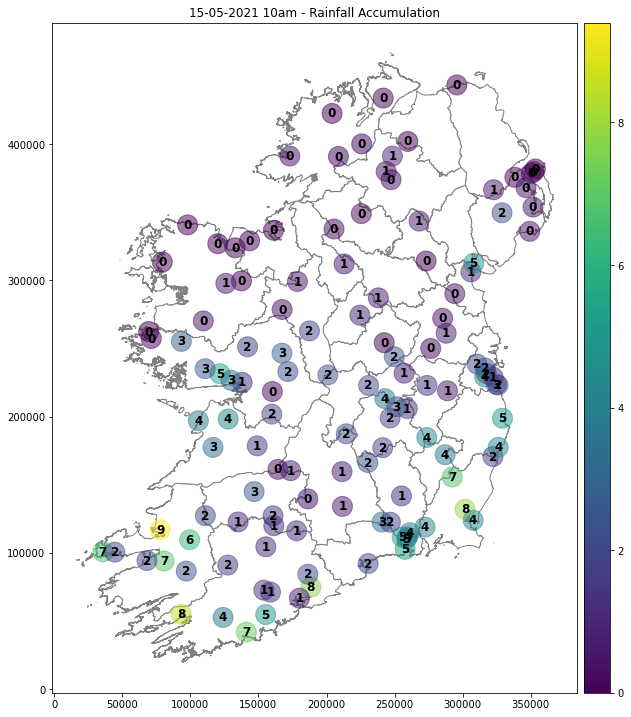

In [5]:
plot_wow_data(gdf_of_interest = gdf_rain_combined, type_of_plot = "Rainfall Accumulation", 
              buffer_val = 0, flags = None)

# First Guess Check

## Adapted Github Example

In [6]:
lats = np.array([60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60])
lons = 10 + np.array([i*0.005 for i in range(len(lats))])
elevs = np.zeros(len(lats))
values = np.round(10*np.sin(lons*2*np.pi/(max(lons)-min(lons))),2)
obs_to_check = np.ones(len(lats))
background_values = np.zeros(len(lats))
background_elab_type = titanlib.MedianOuterCircle
N = len(lats)
num_min_outer = 3
num_max_outer = 10
inner_radius = 20000
outer_radius = 50000
num_iterations = 10
num_min_prof = 1
min_elev_diff = 100
min_horizontal_scale = 250 
max_horizontal_scale = 100000
kth_closest_obs_horizontal_scale = 2
vertical_scale = 200
tpos = np.ones(N) * 16
tneg = np.ones(N) * 16
eps2 = np.ones(N) * 0.5
values_mina = values - 20
values_maxa = values + 20
values_minv = values - 1
values_maxv = values + 1
debug = False
points = titanlib.Points(lats, lons, elevs)

flags = titanlib.sct_resistant(points, values, obs_to_check, background_values, background_elab_type, 
                               num_min_outer, num_max_outer, inner_radius, outer_radius, num_iterations, 
                               num_min_prof, min_elev_diff, min_horizontal_scale, max_horizontal_scale, 
                               kth_closest_obs_horizontal_scale, vertical_scale, values_mina, values_maxa, 
                               values_minv, values_maxv, eps2, tpos, tneg, debug)

flags

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([-999., -999., -999., -999., -999., -999., -999., -999., -999.,
        -999., -999.], dtype=float32)]

## Custom Example

In [7]:
lats = [53, 53.5, 53, 52.5, 53, 54, 53.5, 52.5, 52, 52.5, 53.5]
lons = [-8, -8, -7.5, -8, -8.5, -8, -7, -7, -8, -9, -9]

vals = [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]

test_df = pd.DataFrame(list(zip(lats, lons, vals)))

test_df.rename(columns={0: "Latitude", 1: "Longitude", 2: "Air Temperature"}, inplace = True)

test_df["Day"] = "n/a"
test_df["Month"] = "n/a"
test_df["Year"] = "n/a"
test_df["Time"] = "n/a"

# Convert data of interest into a GeoDataFrame for plotting
test_gdf = geopandas.GeoDataFrame(test_df, 
                                  geometry=geopandas.points_from_xy(test_df.Longitude, 
                                                                    test_df.Latitude))

test_gdf.crs = {"init":"epsg:4326"} # initialise the dataframe to have a crs
test_gdf = test_gdf.to_crs({'init': 'epsg:29902'}) # convert crs to Irish Grid Projection

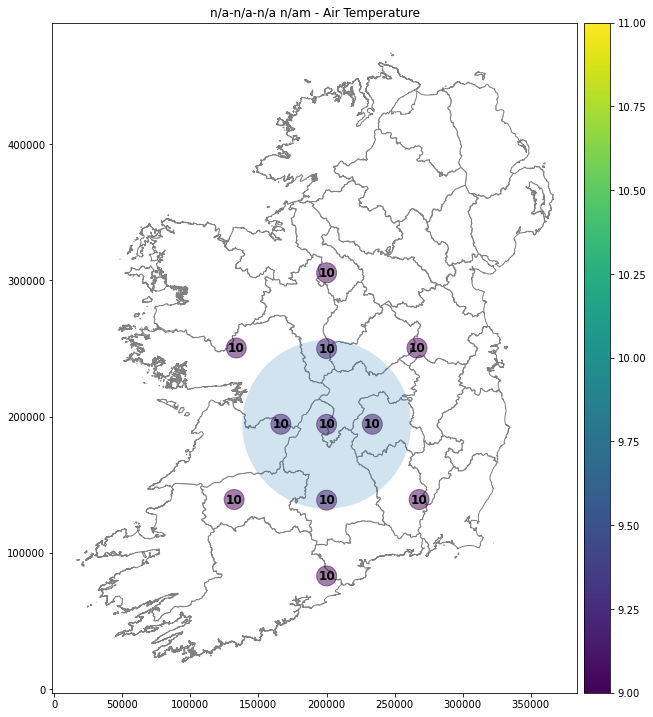

In [8]:
buffer_val_list = np.zeros(len(test_gdf), dtype = int)
buffer_val_list[0] = 62000
buffer_val_list = list(buffer_val_list)

plot_wow_data(test_gdf, type_of_plot = "Air Temperature", 
                  buffer_val = buffer_val_list, flags = None)

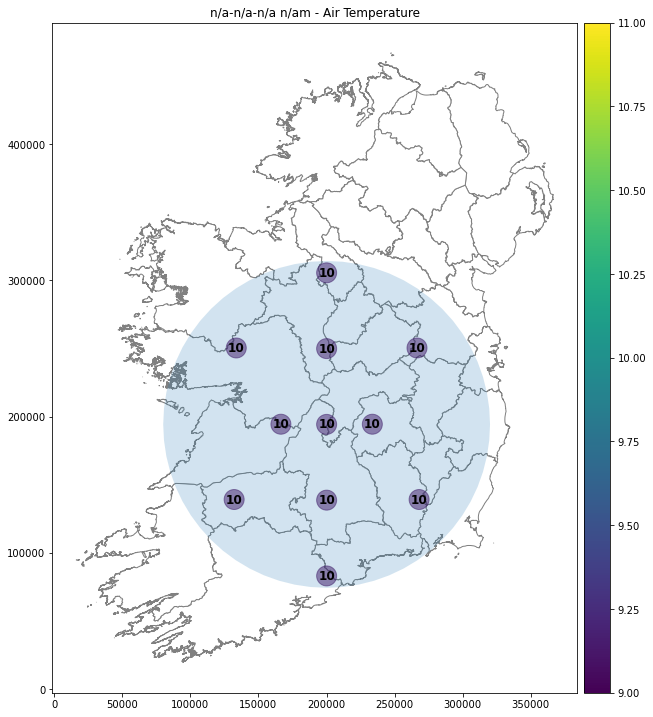

In [9]:
buffer_val_list = np.zeros(len(test_gdf), dtype = int)
buffer_val_list[0] = 120000
buffer_val_list = list(buffer_val_list)

plot_wow_data(test_gdf, type_of_plot = "Air Temperature", 
                  buffer_val = buffer_val_list, flags = None)

In [10]:
elevs = np.zeros(len(lats))
obs_to_check = np.ones(len(lats))
background_values = np.zeros(len(lats))
background_elab_type = titanlib.MedianOuterCircle
N = len(test_gdf)
num_min_outer = 3
num_max_outer = 999 # Our goal is not to optimize speed here so let's include all observations
inner_radius = 62000
outer_radius = 120000
num_iterations = 10
num_min_prof = 1
min_elev_diff = 100
min_horizontal_scale = 250 
max_horizontal_scale = 100000
kth_closest_obs_horizontal_scale = 2
vertical_scale = 200

tpos = np.ones(N) * 3 # Let's flag anything 3 standard deviations away from the background val
tneg = np.ones(N) * 3 # Let's flag anything 3 standard deviations away from the background val

eps2 = np.ones(N) * 0.5

values = np.array(test_gdf["Air Temperature"], dtype=float)

# Let's Purposefully create a very large admissible range for understanding background vals
# as otherwise the value of the background is bounded by mina and maxa.
values_mina = values.copy() - 1000 
values_maxa = values.copy() + 1000

values_minv = values - 1
values_maxv = values + 1
debug = False

points = titanlib.Points(test_gdf["Latitude"], test_gdf["Longitude"], elevs)

### Flag 11 - Isolated inner circle (< 2 stations)

In [11]:
inner_radius = 62000

flags = titanlib.sct_resistant(points, values, obs_to_check, background_values, background_elab_type, 
                               num_min_outer, num_max_outer, inner_radius, outer_radius, num_iterations, 
                               num_min_prof, min_elev_diff, min_horizontal_scale, max_horizontal_scale, 
                               kth_closest_obs_horizontal_scale, vertical_scale, values_mina, values_maxa, 
                               values_minv, values_maxv, eps2, tpos, tneg, debug)

flags

[array([ 0,  0,  0,  0,  0,  0, 11, 11,  0, 11, 11], dtype=int32),
 array([-999., -999., -999., -999., -999., -999., -999., -999., -999.,
        -999., -999.], dtype=float32)]

orange: Stations that are inner circle isolated (< 2 neighbours)


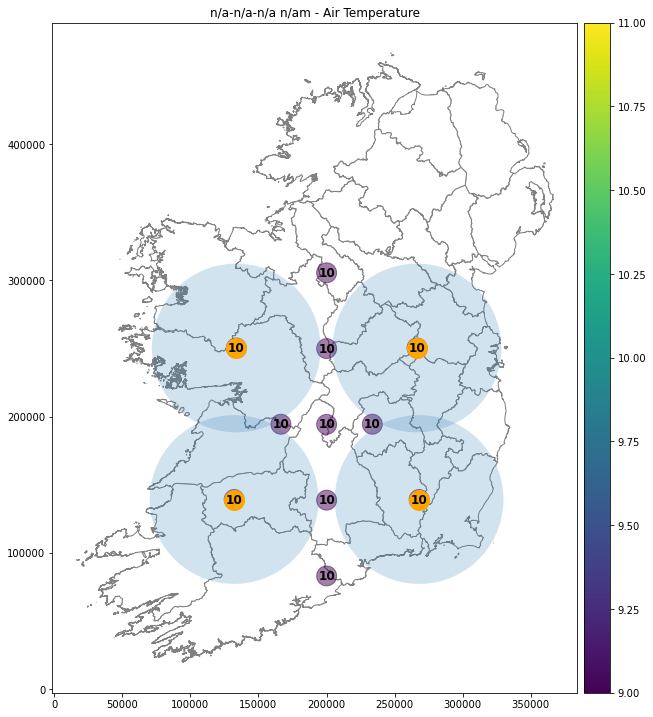

In [12]:
binary_flags = (flags[0] != 0)

buffer_val_list = np.zeros(len(binary_flags), dtype = int)
indices = [i for i, x in enumerate(binary_flags) if x == 1]
buffer_val_list[indices] = inner_radius
buffer_val_list = list(buffer_val_list)

plot_wow_data(test_gdf, type_of_plot = "Air Temperature", 
                  buffer_val = buffer_val_list, flags = flags[0])

### Flag 12 - Isolated outer circle (< num_min_outer stations)

In [13]:
outer_radius = 75000 # decreased outer radius to cause flag 12 (isolated outer circle)
inner_radius = 70000 # increased inner radius to avoid flag 11 (isolated inner circle)
num_min_outer = 3 # same as before, just a reminder

flags = titanlib.sct_resistant(points, values, obs_to_check, background_values, background_elab_type, 
                               num_min_outer, num_max_outer, inner_radius, outer_radius, num_iterations, 
                               num_min_prof, min_elev_diff, min_horizontal_scale, max_horizontal_scale, 
                               kth_closest_obs_horizontal_scale, vertical_scale, values_mina, values_maxa, 
                               values_minv, values_maxv, eps2, tpos, tneg, debug)

flags

[array([ 0,  0,  0,  0,  0, 12,  0,  0, 12,  0,  0], dtype=int32),
 array([-999., -999., -999., -999., -999., -999., -999., -999., -999.,
        -999., -999.], dtype=float32)]

pink: Stations that are outer circle isolated (< num_min_outer neighbours)


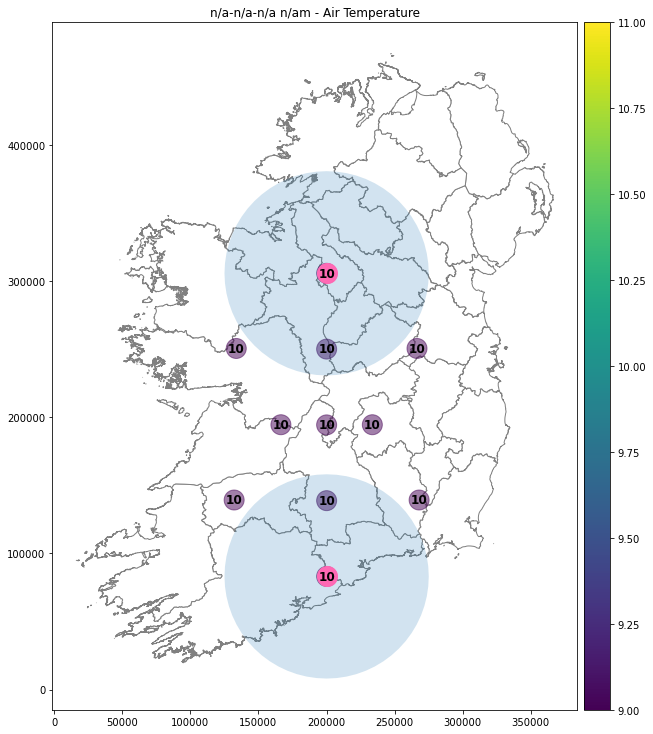

In [14]:
binary_flags = (flags[0] != 0)

buffer_val_list = np.zeros(len(binary_flags), dtype = int)
indices = [i for i, x in enumerate(binary_flags) if x == 1]
buffer_val_list[indices] = outer_radius
buffer_val_list = list(buffer_val_list)

plot_wow_data(test_gdf, type_of_plot = "Air Temperature", 
                  buffer_val = buffer_val_list, flags = flags[0])

### Flag -999 - Station not checked

In [15]:
outer_radius = 120000 # increased outer radius to avoid flag 12 (isolated outer circle)
inner_radius = 70000 # increased inner radius to avoid flag 11 (isolated inner circle)
num_min_outer = 3 # same as before

obs_to_check = np.ones(len(lats))
dont_check = [3, 8, 10]
obs_to_check[dont_check] = 0


flags = titanlib.sct_resistant(points, values, obs_to_check, background_values, background_elab_type, 
                               num_min_outer, num_max_outer, inner_radius, outer_radius, num_iterations, 
                               num_min_prof, min_elev_diff, min_horizontal_scale, max_horizontal_scale, 
                               kth_closest_obs_horizontal_scale, vertical_scale, values_mina, values_maxa, 
                               values_minv, values_maxv, eps2, tpos, tneg, debug)

flags

[array([   0,    0,    0, -999,    0,    0,    0,    0, -999,    0, -999],
       dtype=int32),
 array([-999., -999., -999., -999., -999., -999., -999., -999., -999.,
        -999., -999.], dtype=float32)]

grey: Stations that have not been checked


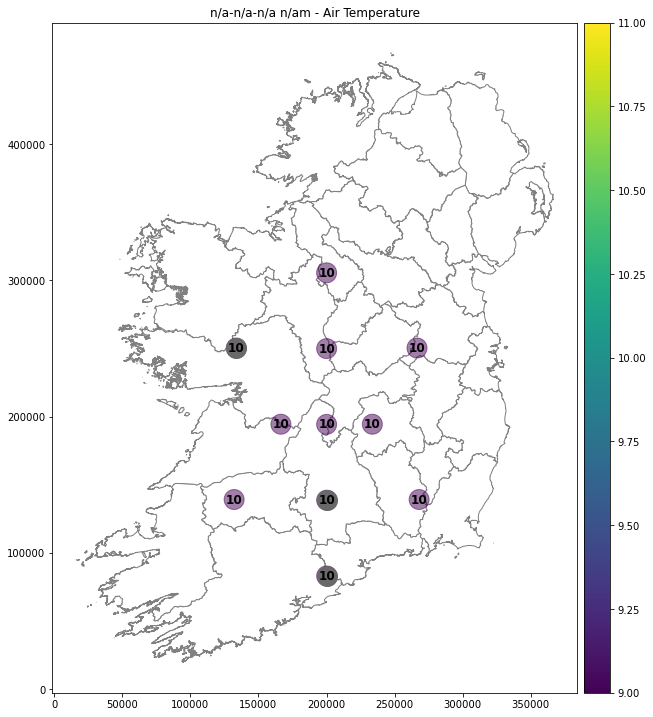

In [16]:
plot_wow_data(test_gdf, type_of_plot = "Air Temperature", 
                  buffer_val = 0, flags = flags[0])

### Flag 1 - Bad observation (rejected by SCT)

The SCT compares each observation to what is expected given the other observations in the nearby area (the "neighbourhood"). If the deviation is large, the observation is removed. When a given observation is being processed, the outer_radius defines which other observations will be used to determine if the observation should be flagged or not. This can be computationally expensive if a new circle is used when processing every observation. So, to save time, the calculations used for one observation can be reused for all other observations within the inner_radius.

So, if we want to flag the central observation as bad (as an example) we will need to change the value of some of the inner and outer observations. To know what changes to make it is helpful to have a conceptual understanding of the mathematics involved.
<br>
<br>
<br>

**Parameters/Calculations:**

The first important parameter to understand is $\chi$ and it is calculated as:

$$\chi = \sqrt{\textrm{analysis residual} * \textrm{cv analysis residual}}$$

where  $\textrm{analysis residual} = y_o - y_a$ and $\textrm{cv analysis residual} = y_o - y_{av}$

This parameter $\chi$ is then used to calculate a z score:

$$z = \frac{\chi - \mu}{\sigma + \sigma_\mu}$$

where $\mu = \textrm{median}(\chi)$, $\sigma = \textrm{IQR}(\chi)$, $\sigma_\mu = \sigma / \sqrt{n}$. Note that these statistics are based on the n observations that are within the inner circle and with a cv analysis within the range of admissible values.


SCT fails when:
$$z > tpos, \quad y_o >= y_{av}$$
$$z > tneg, \quad y_o <  y_{av}$$
<br>
<br>
<br>

**Note 1:** If there is no variation in the inner circle (in fact if the inter quartile range = 0) then to avoid a divide by zero error the sct is exited early and the value is left as "good".

**Note 2:** These calculations all depend heavily on the value of the background so it is essential that the value is representative of the true data. The method of calculation is also important as for example changing one value in the outer circle to be a very large outlier will cause no change to the background value if the method of calculation is MedianOuterCircle, conversely MeanOuterCircle is susceptible to those large outliers.
<br>
<br>
<br>

**Flagging Observations as Bad:**

An observation is flagged when $z > \textrm{given threshold}$

So, for an observation to be flagged, $\chi$ must be large, $\mu$ must be small and both $\sigma$ and $\sigma_\mu$ cannot be too large. The given threshold must also not be too large.

Practically speaking, for an observation to be flagged: 
1. The difference between the observation being tested and the background must be high. i.e. if the observation being tested and the background value are close the value is probably correct.
2. The median of the differences between the inner circle observations and the background must be small. i.e. most of the other observations within the inner circle should be close to the background value, indicating that the other inner circle points and the background agree with each other and the observation being tested is the odd one out.
3. There cannot be large variances between the differences between the inner circle observations and the background values. i.e. if the inner circle values are all over the place, some agreeing with the background, others disagreeing it is more difficult to conclude that the central observation is the odd one out and should be flagged.

In [17]:
background_elab_type = titanlib.MedianOuterCircle

points = titanlib.Points(test_gdf["Latitude"], test_gdf["Longitude"], elevs)

obs_to_check = np.ones(len(lats))

test_gdf["Air Temperature"] = np.full(len(test_gdf), 10)

# Outer circle stations
# Need to be large enough that the background is high 
# In this case we are using MedianOuterCircle so the 
# Background value will be 100
test_gdf.loc[10, "Air Temperature"] = 100
test_gdf.loc[9, "Air Temperature"] = 100
test_gdf.loc[8, "Air Temperature"] = 100
test_gdf.loc[7, "Air Temperature"] = 100
test_gdf.loc[6, "Air Temperature"] = 100
test_gdf.loc[5, "Air Temperature"] = 100

# Inner circle stations
# Need to have some vairation (to avoid a dividing by zero error)
# Need to mostly agree with the background value (indicating the central value is the odd one out)
# Should not have too high variation
test_gdf.loc[4, "Air Temperature"] = 101
test_gdf.loc[3, "Air Temperature"] = 98
test_gdf.loc[2, "Air Temperature"] = 97
test_gdf.loc[1, "Air Temperature"] = 100

tpos = np.ones(N) * 2 # Let's flag anything 2 standard deviations away from the background val
tneg = np.ones(N) * 2 # Let's flag anything 2 standard deviations away from the background val




values = np.array(test_gdf["Air Temperature"], dtype=float)


flags = titanlib.sct_resistant(points, values, obs_to_check, background_values, background_elab_type, 
                               num_min_outer, num_max_outer, inner_radius, outer_radius, num_iterations, 
                               num_min_prof, min_elev_diff, min_horizontal_scale, max_horizontal_scale, 
                               kth_closest_obs_horizontal_scale, vertical_scale, values_mina, values_maxa, 
                               values_minv, values_maxv, eps2, tpos, tneg, debug = True)

flags

[array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([   2.3227105, -999.       , -999.       , -999.       ,
        -999.       , -999.       , -999.       , -999.       ,
        -999.       , -999.       , -999.       ], dtype=float32)]

red: Stations that have been flagged as bad


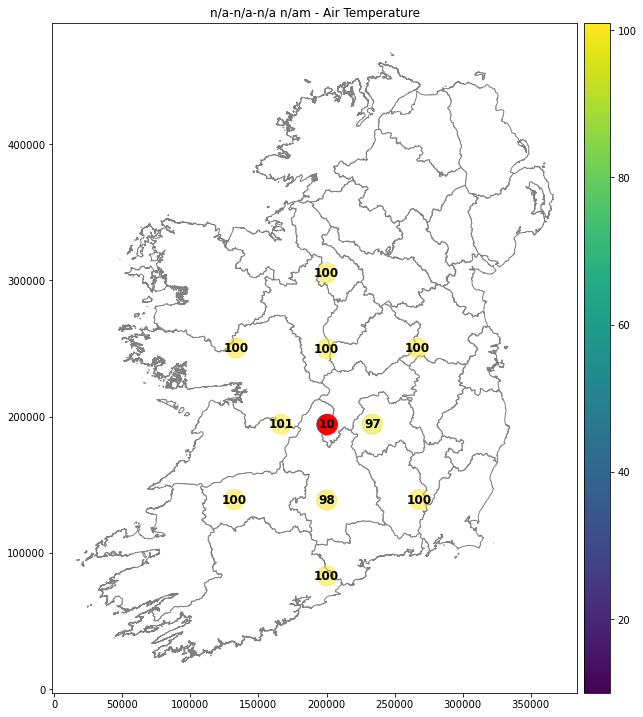

In [18]:
plot_wow_data(test_gdf, type_of_plot = "Air Temperature", 
                  buffer_val = 0, flags = flags[0])

In this example we can see the central observation is being flagged as bad (1) and we can also see that the corresponding z score it had was 2.3227105 (which is greater than the allowed 2 standard deviations we set).

**Note:** The SCT check appears to be much more resistant to flagging this example. It was necessary to both lower the threshold as well as make the inner circle observations occur more closely to 100. This resistance stems from the resulting chi_stat vector which has much higher values for the non-centroid observation resulting in a higher mean, IQR etc which causes a much lower z value.

This is not an error by any means, just worth noting!

## Example on Real World Data

In [19]:
long_np = np.array(gdf_temp_combined["Longitude"])
lat_np = np.array(gdf_temp_combined["Latitude"])
elevs_np = np.array(gdf_temp_combined["Altitude"])

points = titanlib.Points(lat_np, long_np, elevs_np)
values = np.array(gdf_temp_combined["Air Temperature"], dtype=float)

obs_to_check = np.ones(len(lats))
background_values = np.zeros(len(lats))
background_elab_type = titanlib.MedianOuterCircle
N = len(lat_np)
num_min_outer = 3
num_max_outer = 999 # Our goal is not to optimize speed here so let's include all observations
inner_radius = 20000
outer_radius = 40000
num_iterations = 10
num_min_prof = 1
min_elev_diff = 100
min_horizontal_scale = 250 
max_horizontal_scale = 100000
kth_closest_obs_horizontal_scale = 2
tpos = np.ones(N) * 3 # Let's flag anything 3 standard deviations away from the background val
tneg = np.ones(N) * 3 # Let's flag anything 3 standard deviations away from the background val

eps2 = np.ones(N) * 0.5

values_mina = values.copy() - 20
values_maxa = values.copy() + 20

values_minv = values - 1
values_maxv = values + 1
debug = False


flags = titanlib.sct_resistant(points, values, obs_to_check, background_values, background_elab_type, 
                               num_min_outer, num_max_outer, inner_radius, outer_radius, num_iterations, 
                               num_min_prof, min_elev_diff, min_horizontal_scale, max_horizontal_scale, 
                               kth_closest_obs_horizontal_scale, vertical_scale, values_mina, values_maxa, 
                               values_minv, values_maxv, eps2, tpos, tneg, debug = True)

flags

[array([11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 11,  0,  0,
        11,  0,  0,  0,  0,  0, 11,  0,  0, 12,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 11,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 11,  0,  0,
         0,  0,  0, 11, 11, 11, 11,  0,  0,  0, 11, 11,  0,  0, 11,  0,  0,
         0,  0, 11, 11,  0,  0,  0,  0,  0, 11,  0, 11, 11,  0, 11, 11, 11,
         0, 11,  0,  0,  0,  0, 11,  0,  0,  0, 11, 11,  0,  0,  0, 11,  0,
         0,  0, 11, 11, 11, 11,  0,  0, 11, 11,  0,  0,  0, 11,  0, 11, 11,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32),
 array([-999., -999., -999., -999., -999., -999., -999., -999., -999.,
        -999., -999., -999., -999., -999., -999., -999., -999., -999.,
        -999., -999., -999., -999., -999., -999., -999., -999., -999.,
        -999., -999., -999.,

orange: Stations that are inner circle isolated (< 2 neighbours)
pink: Stations that are outer circle isolated (< num_min_outer neighbours)


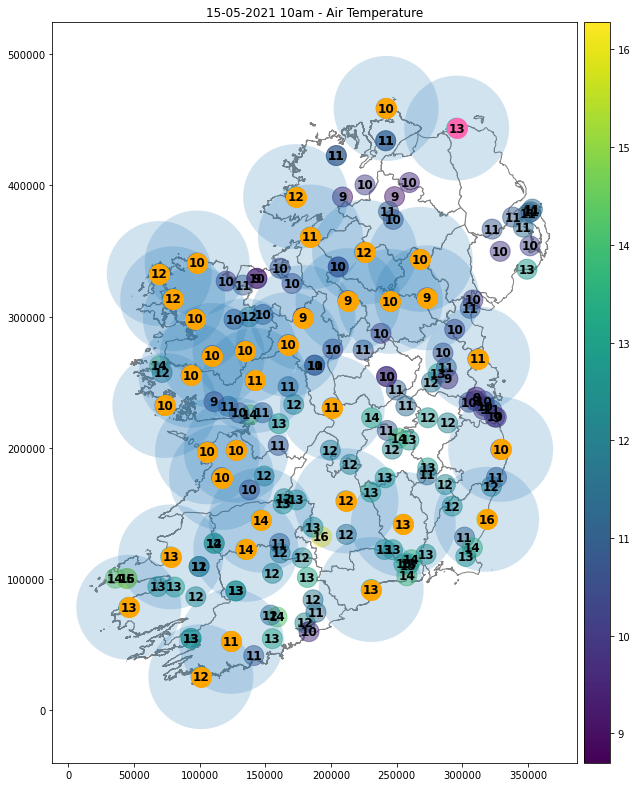

In [20]:
binary_flags = (flags[0] != 0)

buffer_val_list = np.zeros(len(gdf_temp_combined), dtype = int)
indices = [i for i, x in enumerate(binary_flags) if x == 1]
buffer_val_list[indices] = outer_radius
buffer_val_list = list(buffer_val_list)

plot_wow_data(gdf_temp_combined, type_of_plot = "Air Temperature", 
            buffer_val = buffer_val_list, flags = flags[0])